In [1]:
#Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


In [2]:
#load Datasets
df = pd.read_csv("Train_data.csv")

In [3]:
#Display the first five rows
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
df.tail()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
7155,H5290,2012,1.000000,1,V,V,V,U,NaN,1,2001.0,.,NaN,0
7156,H5926,2013,1.000000,0,V,V,V,U,NaN,2,1980.0,.,NaN,1
7157,H6204,2016,0.038251,0,V,V,V,U,NaN,1,1992.0,.,NaN,0
7158,H6537,2013,1.000000,0,V,V,V,U,NaN,1,1972.0,.,NaN,0
7159,H7470,2014,1.000000,0,V,V,V,U,NaN,1,2004.0,.,NaN,0


In [5]:
print(df['Claim'].value_counts())


Claim
0    5526
1    1634
Name: count, dtype: int64


In [6]:
df.shape

(7160, 14)

In [7]:
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim'],
      dtype='object')

In [11]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if df[col].dtype != 'object']

print('categorical columns:', cat_col)
print('Numerical columns:', num_col)

categorical columns: ['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'NumberOfWindows', 'Geo_Code']
Numerical columns: ['YearOfObservation', 'Insured_Period', 'Residential', 'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'Claim']


In [12]:
df[cat_col].nunique()

Customer Id         7160
Building_Painted       2
Building_Fenced        2
Garden                 2
Settlement             2
NumberOfWindows       11
Geo_Code            1307
dtype: int64

In [13]:
df.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [14]:
df.isnull().mean().mul(100).round(2)


Customer Id           0.00
YearOfObservation     0.00
Insured_Period        0.00
Residential           0.00
Building_Painted      0.00
Building_Fenced       0.00
Garden                0.10
Settlement            0.00
Building Dimension    1.48
Building_Type         0.00
Date_of_Occupancy     7.09
NumberOfWindows       0.00
Geo_Code              1.42
Claim                 0.00
dtype: float64

In [15]:
df = df.drop(columns=["Customer Id", "Geo_Code"])


In [16]:
#Fix missing no

df["NumberOfWindows"] = (df["NumberOfWindows"].replace(".", np.nan))

df["NumberOfWindows"] = pd.to_numeric(df["NumberOfWindows"],errors="coerce")


In [17]:
df["Garden"] = df["Garden"].fillna(df["Garden"].mode()[0])

df["Building Dimension"] = df["Building Dimension"].fillna(
    df["Building Dimension"].median())



In [18]:
#Engineer building Date and handle missing values reasons is that Models learn risk from age, not from calendar years.

# Step 1: Compute building age
df["Building_Age"] = df["YearOfObservation"] - df["Date_of_Occupancy"]

# Step 2: Fill missing ages with median
df["Building_Age"] = df["Building_Age"].fillna(df["Building_Age"].median())

# Step 3: Drop original column
df = df.drop(columns=["Date_of_Occupancy"])



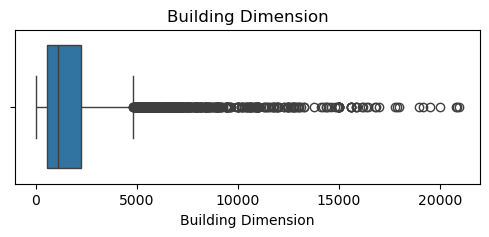

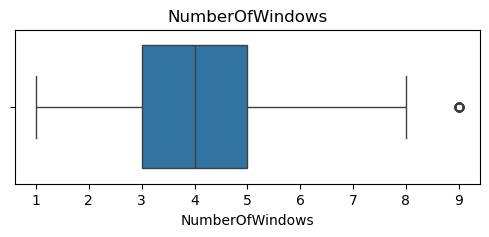

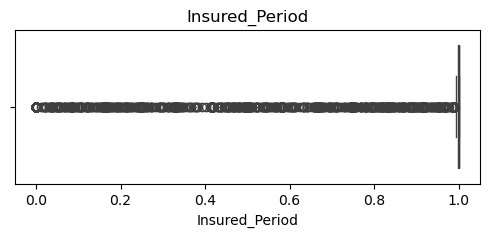

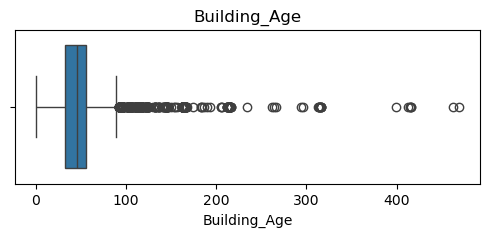

In [19]:
numeric_cols = ["Building Dimension", "NumberOfWindows", "Insured_Period", "Building_Age"]

for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


In [20]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")


Building Dimension: 572 outliers
NumberOfWindows: 49 outliers
Insured_Period: 1237 outliers
Building_Age: 704 outliers


In [21]:
#To handle Outliers using Cap/Winsori

numeric_cols = ["Building Dimension", "NumberOfWindows", "Insured_Period", "Building_Age"]

for col in numeric_cols:
    lower = df[col].quantile(0.05)  # 5th percentile
    upper = df[col].quantile(0.95)  # 95th percentile
    df[col] = np.clip(df[col], lower, upper)

print("Outliers capped for numeric columns.")


Outliers capped for numeric columns.


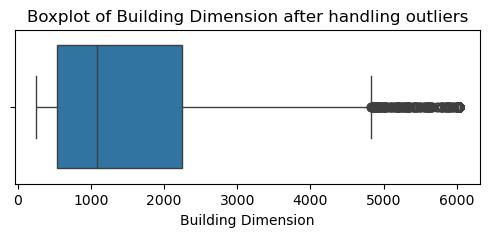

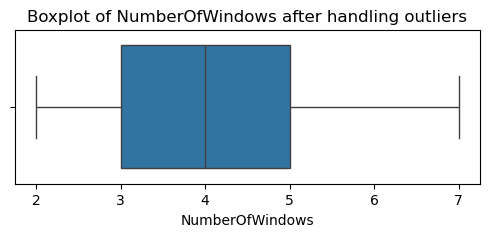

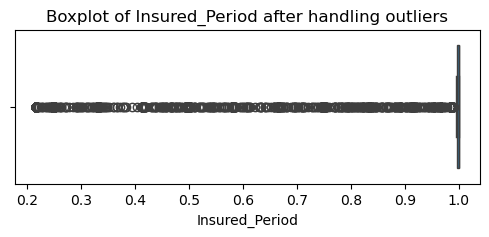

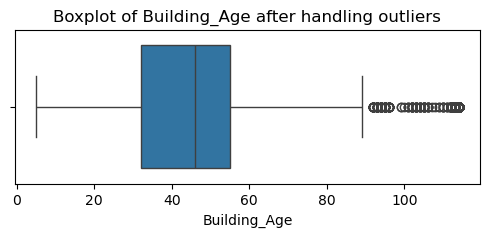

In [22]:
for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} after handling outliers")
    plt.show()


In [23]:
# Count of missing values per column
print(df.isna().sum())

# Percentage of missing values
print(df.isna().mean() * 100)


YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                   0
Settlement               0
Building Dimension       0
Building_Type            0
NumberOfWindows       3618
Claim                    0
Building_Age             0
dtype: int64
YearOfObservation      0.000000
Insured_Period         0.000000
Residential            0.000000
Building_Painted       0.000000
Building_Fenced        0.000000
Garden                 0.000000
Settlement             0.000000
Building Dimension     0.000000
Building_Type          0.000000
NumberOfWindows       50.530726
Claim                  0.000000
Building_Age           0.000000
dtype: float64


In [24]:
print(df["NumberOfWindows"].unique())


[nan  4.  3.  2.  5.  6.  7.]


In [25]:
# Missing indicator
df['NumberOfWindows_missing'] = df['NumberOfWindows'].isna().astype(int)

# Median imputation
df['NumberOfWindows'] = df['NumberOfWindows'].fillna(df['NumberOfWindows'].median())


In [26]:
df['NumberOfWindows'].unique()


array([4., 3., 2., 5., 6., 7.])

In [27]:
#Confirm no missing values remaining

df['NumberOfWindows'].isna().sum()


np.int64(0)

In [28]:
#sort to visually confirm range

np.sort(df['NumberOfWindows'].unique())


array([2., 3., 4., 5., 6., 7.])

In [29]:
df['NumberOfWindows_missing'].value_counts()


NumberOfWindows_missing
1    3618
0    3542
Name: count, dtype: int64

In [30]:
df.groupby('NumberOfWindows_missing')['Claim'].mean()


NumberOfWindows_missing
0    0.244777
1    0.211996
Name: Claim, dtype: float64

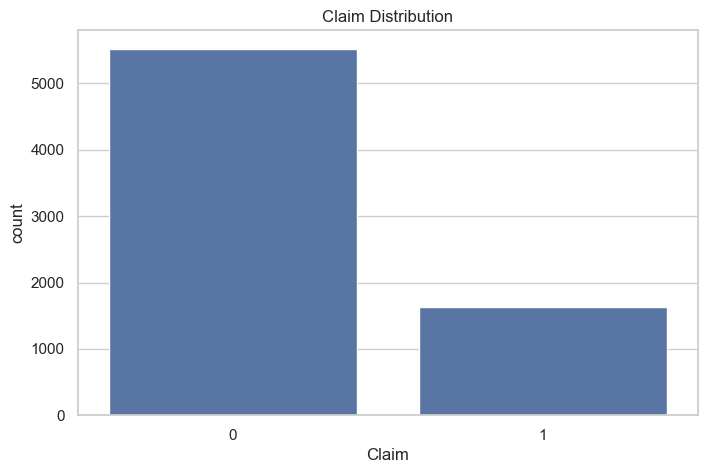

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))

sns.countplot(x='Claim', data=df)
plt.title('Claim Distribution')
plt.show()


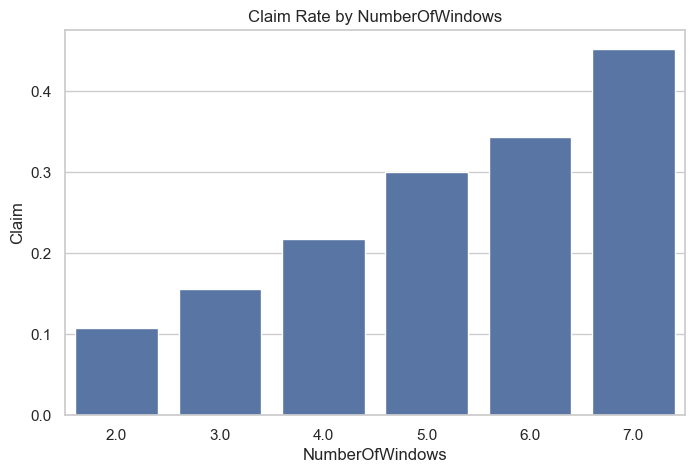

In [32]:
plt.figure(figsize=(8,5))

sns.barplot(x='NumberOfWindows', y='Claim', data=df, errorbar=None)
plt.title('Claim Rate by NumberOfWindows')
plt.show()




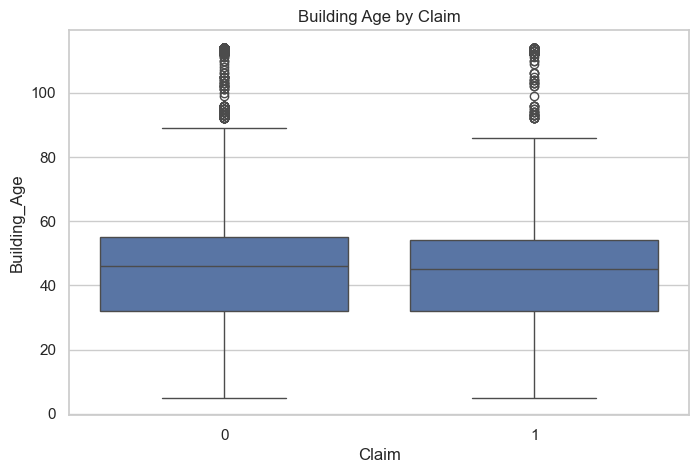

In [33]:
plt.figure(figsize=(8,5))

sns.boxplot(x='Claim', y='Building_Age', data=df)
plt.title('Building Age by Claim')
plt.show()


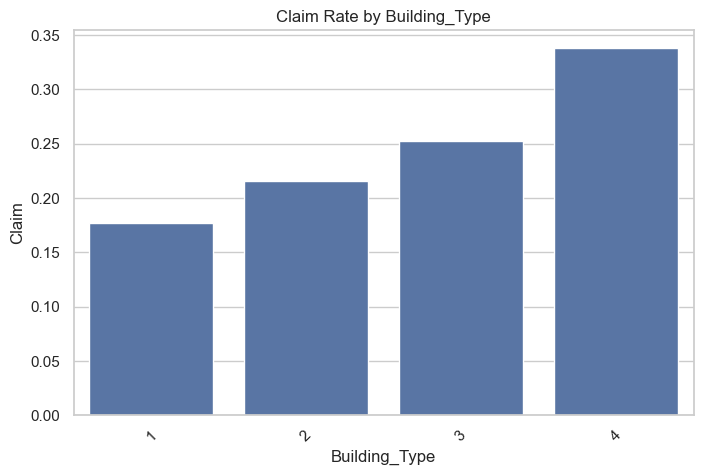

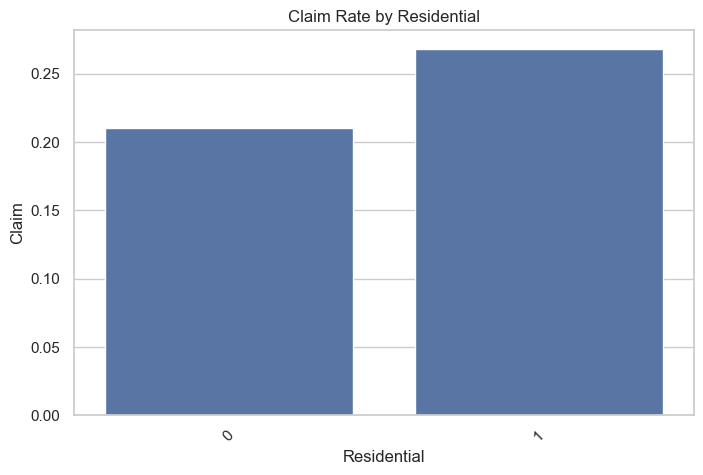

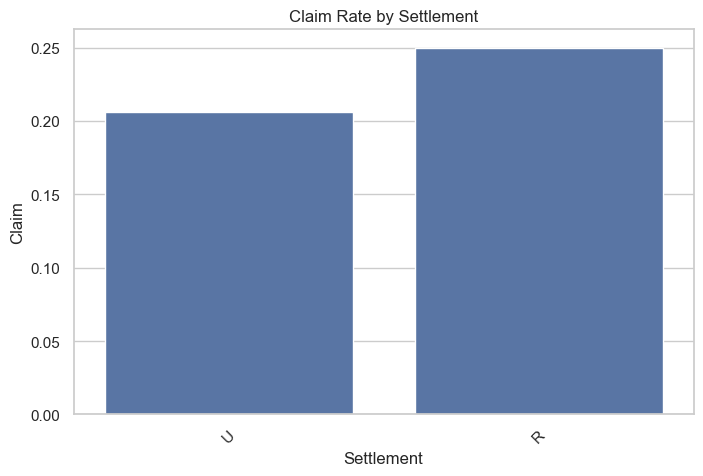

In [34]:
categorical_cols = ['Building_Type', 'Residential', 'Settlement']

for col in categorical_cols:
    plt.figure(figsize=(8,5))
    sns.barplot(x=col, y='Claim', data=df, errorbar=None)
    plt.title(f'Claim Rate by {col}')
    plt.xticks(rotation=45)
    plt.show()


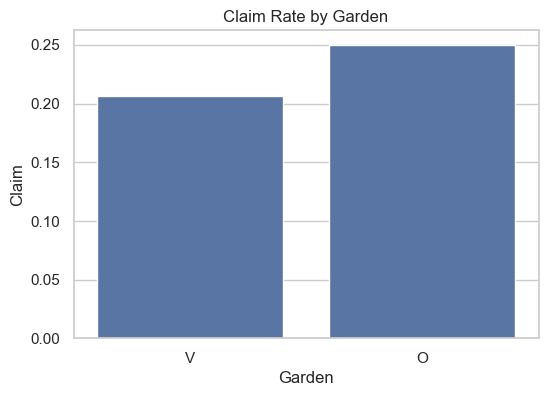

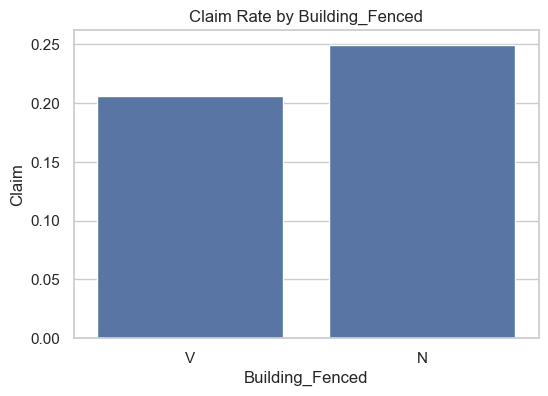

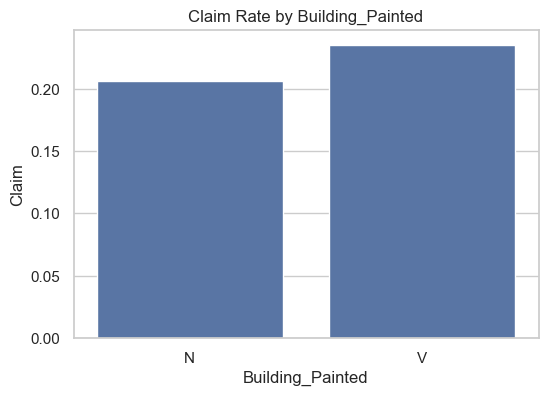

In [35]:
binary_cols = ['Garden','Building_Fenced','Building_Painted']

for col in binary_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y='Claim', data=df, errorbar=None)
    plt.title(f'Claim Rate by {col}')
    plt.show()


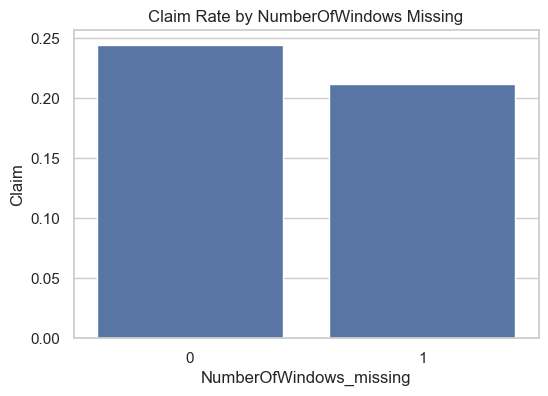

In [36]:


plt.figure(figsize=(6,4))

sns.barplot(x='NumberOfWindows_missing', y='Claim', data=df, errorbar=None)
plt.title('Claim Rate by NumberOfWindows Missing')
plt.show()


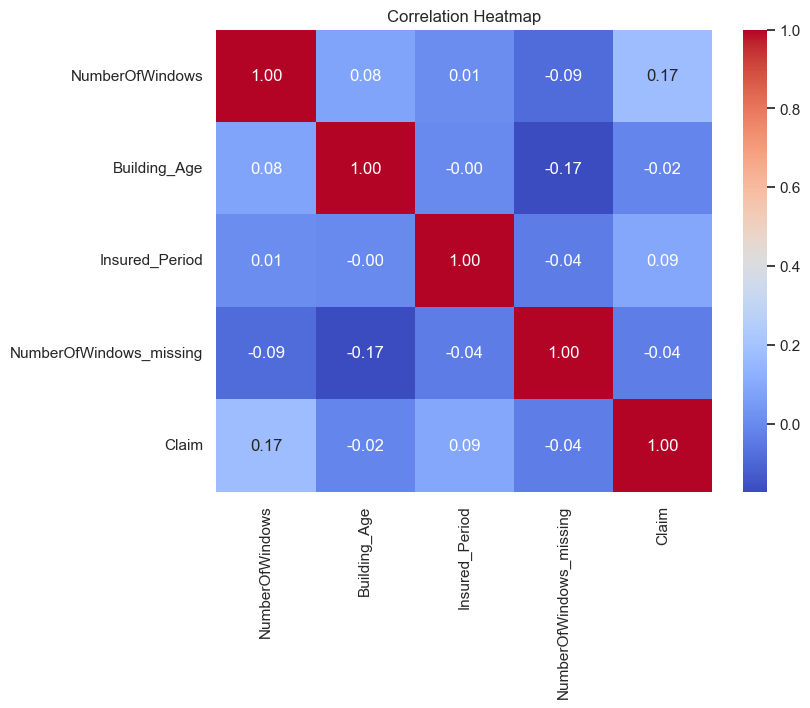

In [37]:
#compute correlation matrix

numeric_cols = ['NumberOfWindows','Building_Age','Insured_Period','NumberOfWindows_missing']

plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols + ['Claim']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [38]:
# correlation matrix
numeric_cols = [
    'NumberOfWindows',
    'Building_Age',
    'Insured_Period',
    'NumberOfWindows_missing'
]

df[numeric_cols + ['Claim']].corr()


,NumberOfWindows,Building_Age,Insured_Period,NumberOfWindows_missing,Claim
NumberOfWindows,1.000000,0.080042,0.009227,-0.089224,0.171288
Building_Age,0.080042,1.000000,-0.000397,-0.172690,-0.015647
Insured_Period,0.009227,-0.000397,1.000000,-0.039951,0.090516
NumberOfWindows_missing,-0.089224,-0.172690,-0.039951,1.000000,-0.039053
Claim,0.171288,-0.015647,0.090516,-0.039053,1.000000


In [39]:
X = df.drop(columns='Claim')
y = df['Claim']


In [40]:
# 1️⃣ Train/test split
from sklearn.model_selection import train_test_split

X = df.drop(columns='Claim')
y = df['Claim']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2️⃣ Baseline pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = ['NumberOfWindows', 'Insured_Period', 'Building_Age', 'NumberOfWindows_missing']
cat_cols = ['Settlement', 'Building_Type', 'Residential', 'Garden', 'Building_Fenced', 'Building_Painted']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Fit baseline
model.fit(X_train, y_train)

# 3️⃣ L1 pipeline (feature selection)
l1_model = Pipeline([
    ('preprocess', model.named_steps['preprocess']),  # reuse preprocessor
    ('clf', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])

l1_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:

# Feature names from pipeline
feature_names = model.named_steps['preprocess'].get_feature_names_out()

# Coefficients from baseline model
coefficients = model.named_steps['clf'].coef_[0]

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

coef_df


,Feature,Coefficient,Abs_Coefficient
7,cat__Building_Type_4,0.690864,0.690864
3,num__NumberOfWindows_missing,0.606536,0.606536
9,cat__Garden_V,-0.427791,0.427791
4,cat__Settlement_U,-0.418962,0.418962
10,cat__Building_Fenced_V,-0.390354,0.390354
6,cat__Building_Type_3,0.384531,0.384531
0,num__NumberOfWindows,0.357325,0.357325
1,num__Insured_Period,0.266661,0.266661
5,cat__Building_Type_2,0.251983,0.251983
2,num__Building_Age,-0.141557,0.141557


In [42]:
# Feature names from L1 pipeline
feature_names_l1 = l1_model.named_steps['preprocess'].get_feature_names_out()
coefficients_l1 = l1_model.named_steps['clf'].coef_[0]

# DataFrame of L1-selected features
l1_features = pd.DataFrame({
    'Feature': feature_names_l1,
    'Coefficient': coefficients_l1,
    'Abs_Coefficient': np.abs(coefficients_l1)
})

# Only keep non-zero coefficients
selected_features = l1_features[l1_features['Coefficient'] != 0] \
    .sort_values('Abs_Coefficient', ascending=False)

selected_features


,Feature,Coefficient,Abs_Coefficient
9,cat__Garden_V,-1.080408,1.080408
7,cat__Building_Type_4,0.679103,0.679103
3,num__NumberOfWindows_missing,0.535393,0.535393
6,cat__Building_Type_3,0.378874,0.378874
0,num__NumberOfWindows,0.366239,0.366239
1,num__Insured_Period,0.267571,0.267571
5,cat__Building_Type_2,0.235329,0.235329
2,num__Building_Age,-0.147221,0.147221
11,cat__Building_Painted_V,0.115717,0.115717
8,cat__Residential_1,0.090890,0.090890


In [43]:
from sklearn.metrics import classification_report, roc_auc_score

# Baseline model predictions
y_pred_base = model.predict(X_test)
y_proba_base = model.predict_proba(X_test)[:,1]

print("Baseline Model Performance")
print(classification_report(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_base))
print("\n")

# L1 model predictions
y_pred_l1 = l1_model.predict(X_test)
y_proba_l1 = l1_model.predict_proba(X_test)[:,1]

print("L1 Model Performance")
print(classification_report(y_test, y_pred_l1))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_l1))


Baseline Model Performance
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1105
           1       0.57      0.05      0.09       327

    accuracy                           0.77      1432
   macro avg       0.67      0.52      0.48      1432
weighted avg       0.73      0.77      0.69      1432

ROC-AUC: 0.6464513540066696


L1 Model Performance
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      1105
           1       0.32      0.55      0.40       327

    accuracy                           0.62      1432
   macro avg       0.57      0.60      0.56      1432
weighted avg       0.71      0.62      0.65      1432

ROC-AUC: 0.6454467460943445


In [44]:
# 1️⃣ Identify which original columns were kept by L1
# Look at selected_features and only keep the base column names

# Numeric columns
final_num_cols = [c for c in ['NumberOfWindows', 'Insured_Period', 'Building_Age', 'NumberOfWindows_missing']
                  if any(c in f for f in selected_features['Feature'])]

# Categorical columns
final_cat_cols = [c for c in ['Settlement', 'Building_Type', 'Residential', 'Garden', 'Building_Fenced', 'Building_Painted']
                  if any(c in f for f in selected_features['Feature'])]

print("Numeric columns:", final_num_cols)
print("Categorical columns:", final_cat_cols)

# 2️⃣ Build ColumnTransformer with raw columns
preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), final_num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), final_cat_cols)
    ]
)

# 3️⃣ Build final pipeline
final_model = Pipeline([
    ('preprocess', preprocessor_final),
    ('clf', LogisticRegression(
        penalty='l2',
        class_weight='balanced',
        max_iter=1000
    ))
])

# 4️⃣ Fit final model
final_model.fit(X_train, y_train)

# 5️⃣ Evaluate final model
y_pred_final = final_model.predict(X_test)
y_proba_final = final_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_final))


Numeric columns: ['NumberOfWindows', 'Insured_Period', 'Building_Age', 'NumberOfWindows_missing']
Categorical columns: ['Building_Type', 'Residential', 'Garden', 'Building_Painted']
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      1105
           1       0.31      0.55      0.40       327

    accuracy                           0.62      1432
   macro avg       0.57      0.60      0.56      1432
weighted avg       0.71      0.62      0.65      1432

ROC-AUC: 0.6455408416012842


In [45]:
#increase recall
y_proba = model.predict_proba(X_test)[:, 1]

# Try a lower threshold
y_pred_03 = (y_proba >= 0.3).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_03))


              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1105
           1       0.39      0.28      0.33       327

    accuracy                           0.73      1432
   macro avg       0.60      0.58      0.58      1432
weighted avg       0.71      0.73      0.72      1432



In [46]:
#Training with LogisticRegression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)


In [47]:
important_features = coef_df[coef_df['Abs_Coefficient'] > 0.1]['Feature']


In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)


In [49]:
#cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    model, X, y,
    scoring='roc_auc',
    cv=5
)

print(scores)
print("Mean ROC-AUC:", scores.mean())


[0.65780628 0.62410367 0.61905434 0.6511077  0.64591584]
Mean ROC-AUC: 0.6395975651900653


In [50]:
#Train with RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42
)

rf_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', rf)
])


In [51]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(
    rf_model,
    X,
    y,
    scoring='roc_auc',
    cv=cv
)

print("RF ROC-AUC scores:", rf_scores)
print("Mean RF ROC-AUC:", rf_scores.mean())


RF ROC-AUC scores: [0.6493069  0.61673101 0.65752833 0.64212573 0.64507728]
Mean RF ROC-AUC: 0.6421538517320747


In [52]:
#Back to feature Engineering to change representation
df['Building_Age_bin'] = pd.cut(
    df['Building_Age'],
    bins=[0, 10, 30, 60, 100, 200],
    labels=['0-10', '10-30', '30-60', '60-100', '100+']
)

df['Has_Windows'] = (df['NumberOfWindows'] > 0).astype(int)

df['Fenced_Garden'] = (
    df['Building_Fenced'].astype(str) + "_" +
    df['Garden'].astype(str)
)


In [53]:
#Verify if the new features exist
df[['Building_Age', 'Building_Age_bin', 'Has_Windows', 'Fenced_Garden']].head()


,Building_Age,Building_Age_bin,Has_Windows,Fenced_Garden
0,53.0,30-60,1,V_V
1,114.0,100+,1,N_O
2,54.0,30-60,1,V_V
3,53.0,30-60,1,V_V
4,114.0,100+,1,N_O


In [54]:
X = df.drop(columns='Claim')
y = df['Claim']


In [55]:
num_cols = [
    'NumberOfWindows',
    'Insured_Period',
    'Building_Age',
    'NumberOfWindows_missing',
    'Has_Windows'
]

cat_cols = [
    'Settlement',
    'Building_Type',
    'Residential',
    'Garden',
    'Building_Fenced',
    'Building_Painted',
    'Building_Age_bin',
    'Fenced_Garden'
]


In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_balanced = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model_fe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', lr_balanced)
])


In [58]:
#cross-validate
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fe_scores = cross_val_score(
    model_fe,
    X,
    y,
    scoring='roc_auc',
    cv=cv
)

print("Feature-engineered ROC-AUC:", fe_scores)
print("Mean ROC-AUC:", fe_scores.mean())


Feature-engineered ROC-AUC: [0.6513163  0.617618   0.65603664 0.64821703 0.64133837]
Mean ROC-AUC: 0.6429052681849233


In [59]:
#introduction of catboost, because of it's ability to handles categorical features

#define features and target
X = df.drop(columns='Claim')
y = df['Claim']
cat_features = [
    i for i, col in enumerate(X.columns)
    if X[col].dtype.name in ['object', 'category']
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=0
    )

    model.fit(
        X_train,
        y_train,
        cat_features=cat_features
    )

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    roc_auc_scores.append(roc_auc)

print("CatBoost ROC-AUC per fold:", roc_auc_scores)
print("Mean ROC-AUC:", np.mean(roc_auc_scores))


CatBoost ROC-AUC per fold: [0.686672805333984, 0.7069340086069714, 0.7162121023427014, 0.7268628834737847, 0.7260409315455187]
Mean ROC-AUC: 0.7125445462605919


In [60]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [61]:
# Features & target
X = df.drop(columns='Claim')
y = df['Claim']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (7160, 15)
Target shape: (7160,)


In [62]:
# Automatically find categorical columns (object or category dtype)
cat_features = [
    i for i, col in enumerate(X.columns)
    if X[col].dtype.name in ['object', 'category']
]

print("Categorical feature indices:", cat_features)
print("Categorical feature names:", [X.columns[i] for i in cat_features])


Categorical feature indices: [3, 4, 5, 6, 12, 14]
Categorical feature names: ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Age_bin', 'Fenced_Garden']


In [63]:
#compute 5-fold cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
import numpy as np

# Define 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Initialize CatBoost model
    model = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        early_stopping_rounds=50,
        verbose=0  # suppress output for each iteration
    )

    # Create CatBoost pools for categorical features
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    # Train model
    model.fit(train_pool, eval_set=val_pool)

    # Predict probabilities for validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC for this fold
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    roc_auc_scores.append(roc_auc)

    print(f"Fold {fold} ROC-AUC: {roc_auc:.4f}")

# Mean ROC-AUC across all folds
print(f"\nMean ROC-AUC across 5 folds: {np.mean(roc_auc_scores):.4f}")


Fold 1 ROC-AUC: 0.7039
Fold 2 ROC-AUC: 0.7067
Fold 3 ROC-AUC: 0.7312
Fold 4 ROC-AUC: 0.7330
Fold 5 ROC-AUC: 0.7316

Mean ROC-AUC across 5 folds: 0.7213


In [64]:
from catboost import CatBoostClassifier, Pool

# Initialize final model (keep same hyperparameters as CV)
final_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100  # prints progress
)

# Create Pool for the full dataset
full_pool = Pool(X, y, cat_features=cat_features)

# Train the final model
final_model.fit(full_pool)


0:	total: 25.8ms	remaining: 51.6s
100:	total: 2.51s	remaining: 47.3s
200:	total: 5.03s	remaining: 45s
300:	total: 7.91s	remaining: 44.6s
400:	total: 10.9s	remaining: 43.4s
500:	total: 13.6s	remaining: 40.8s
600:	total: 16.2s	remaining: 37.8s
700:	total: 18.8s	remaining: 34.9s
800:	total: 21.4s	remaining: 32s
900:	total: 24s	remaining: 29.3s
1000:	total: 26.8s	remaining: 26.8s
1100:	total: 29.6s	remaining: 24.1s
1200:	total: 32.2s	remaining: 21.4s
1300:	total: 34.8s	remaining: 18.7s
1400:	total: 37.4s	remaining: 16s
1500:	total: 40s	remaining: 13.3s
1600:	total: 42.8s	remaining: 10.7s
1700:	total: 45.6s	remaining: 8.02s
1800:	total: 48.3s	remaining: 5.33s
1900:	total: 50.9s	remaining: 2.65s
1999:	total: 53.4s	remaining: 0us


In [65]:
importance = final_model.get_feature_importance(prettified=True)
print("Feature Importance:")
print(importance)


Feature Importance:
                 Feature Id  Importances
0        Building Dimension    29.698859
1              Building_Age    17.198141
2            Insured_Period    10.131609
3         YearOfObservation     8.880458
4             Building_Type     8.590457
5           NumberOfWindows     7.297975
6          Building_Age_bin     6.338266
7             Fenced_Garden     4.189989
8               Residential     3.156698
9          Building_Painted     2.535803
10  NumberOfWindows_missing     0.639957
11          Building_Fenced     0.566371
12                   Garden     0.461068
13               Settlement     0.314350
14              Has_Windows     0.000000


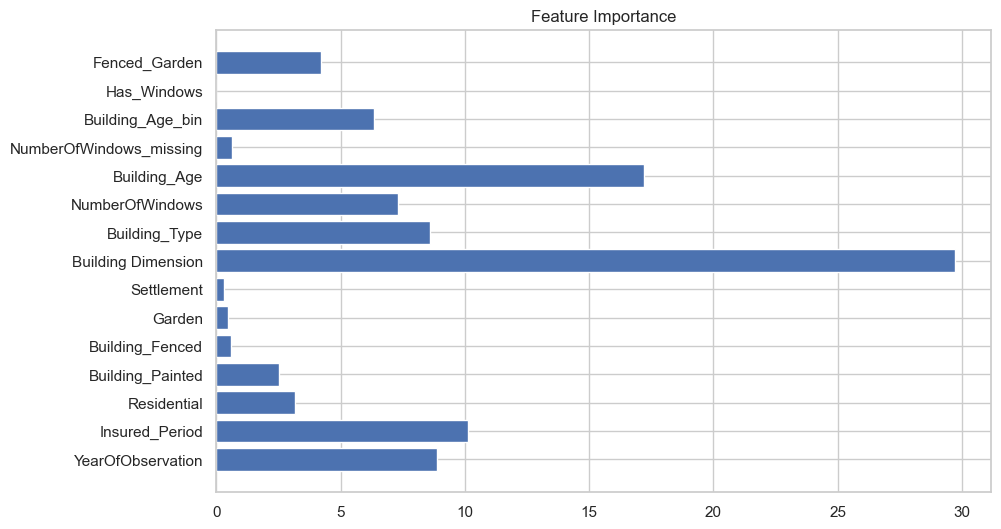

In [66]:
#Visualise feature importance

importance_values = final_model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance_values)
plt.title("Feature Importance")
plt.show()


In [67]:
final_model.save_model("final_catboost_model.cbm")
print("Final model saved as 'final_catboost_model.cbm'")


Final model saved as 'final_catboost_model.cbm'


In [68]:
# from catboost import CatBoostClassifier
# model = CatBoostClassifier()
# model.load_model("final_catboost_model.cbm")
